In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook, we want to use tensorflow object detection models.

First things first, we must know what these pre-trained models can detect. These models are trained on COCO 2017 dataset which has 91 classes. I collected these classes in a text file and added a dummy term named __Background__ to the beginning of the file just to make the model work properly. The following function reads and returns the names of these classes from the file.

In [2]:
def read_class_names(path):
    with open(path, 'r') as f:
        classes_name = f.read().splitlines()
    
    return classes_name

In [3]:
classes_name = read_class_names('/kaggle/input/coco2017-classes/coconames.txt')
classes_name[:10]

['__Background__',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat']

The following function get a model url, extract it, save and return it.

In [4]:
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import get_file

def get_model(model_URL):
    model_name = os.path.basename(model_URL).split('.')[0]
    get_path = get_file(fname=model_name, untar=True, origin=model_URL)
    model = tf.saved_model.load(os.path.join(get_path, 'saved_model'))
    return model

Here, I am going to download and use EfficientDet D4 model. For more models you can check:

[https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md](http://)

In [5]:
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d4_coco17_tpu-32.tar.gz'

model = get_model(url)

158498816/158496448 [==============================] - 1s 0us/step


2023-01-04 10:36:48.353367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:36:48.354344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:36:48.682901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:36:48.683769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 10:36:48.684589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

And now we come to the most important part; We want to define a function that receives the image path, the model and some other arguments as input and detects the objects in the image and draws a bounding box around them.

First, we read the image using the CV2 library which returns the image as a numpy array but the input of pre-trained TensorFlow2 detection models must be a tensor; So we convert numpy array to tensor and expand its dimention.

The output of the model is a dictionary whose three keys are important for us; 'detection_boxes', 'detection classes' and 'detection scores'. all of them are tensor so it's better to convert them to numpy array for easy use. Also, we consider a separate color for each class so that the name of the class and the bouning box can be identified with that color.

Finally, to optimize the bounding boxes, we use soft non-max suppresion algorithm and return the detected objects on the image along with the image itself.

In [6]:
import cv2
from matplotlib import pyplot as plt

def object_detection(image_path, model, classes_name, max_output_size=50, iou_threshold=0.4, score_threshold=0.7, soft_nms_sigma=0.4):
    image = cv2.imread(image_path)
    image2tensor = tf.convert_to_tensor(image, dtype=tf.uint8)
    image2tensor = image2tensor[tf.newaxis,...]
    
    detection = model(image2tensor)
    bboxes = detection['detection_boxes'].numpy()[0]
    class_indexes = detection['detection_classes'].numpy().astype(np.int32)[0]
    class_scores = detection['detection_scores'].numpy()[0]
    
    selected_indices, _ = tf.image.non_max_suppression_with_scores(bboxes, scores=class_scores, max_output_size=max_output_size, iou_threshold=iou_threshold, score_threshold=score_threshold, soft_nms_sigma=soft_nms_sigma)
    
    img_h, img_w, img_c = image.shape
    
    classes_color = np.random.uniform(low=0, high=255, size=(len(classes_name),3))
    
    for i in selected_indices:
        class_score = class_scores[i]
        class_index = class_indexes[i]

        class_label = classes_name[class_index]
        class_color = classes_color[class_index]

        bbox = bboxes[i].tolist()
        ymin, xmin, ymax, xmax = bbox
        ymin, xmin, ymax, xmax = int(ymin*img_h), int(xmin*img_w), int(ymax*img_h), int(xmax*img_w)   
        cv2.rectangle(img=image, pt1=(xmin,ymin), pt2=(xmax,ymax), color=class_color, thickness=2)

        display_txt = '{}: {}%'.format(class_label, class_score)
        cv2.putText(img=image, text=display_txt, org=(xmin,ymin - 10), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=2, color=class_color, thickness=2)
    
    
    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Object Detection Results")
    plt.show()

Now we can select one of the images and detects the objects in the image with the help of the function we have defined.

Obviously, some parameters of the soft-NMS algorithm are tricky and we have to try to find the best values by trial and error several times.

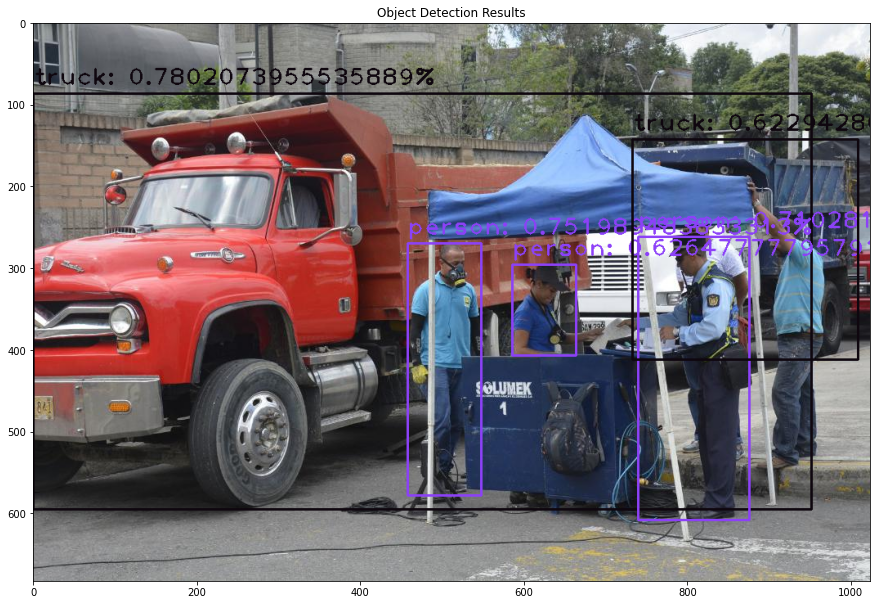

In [49]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/00000b4dcff7f799.jpg'

object_detection(image_path, model, classes_name, max_output_size=20, iou_threshold=0.49, score_threshold=0.5, soft_nms_sigma=0.49)

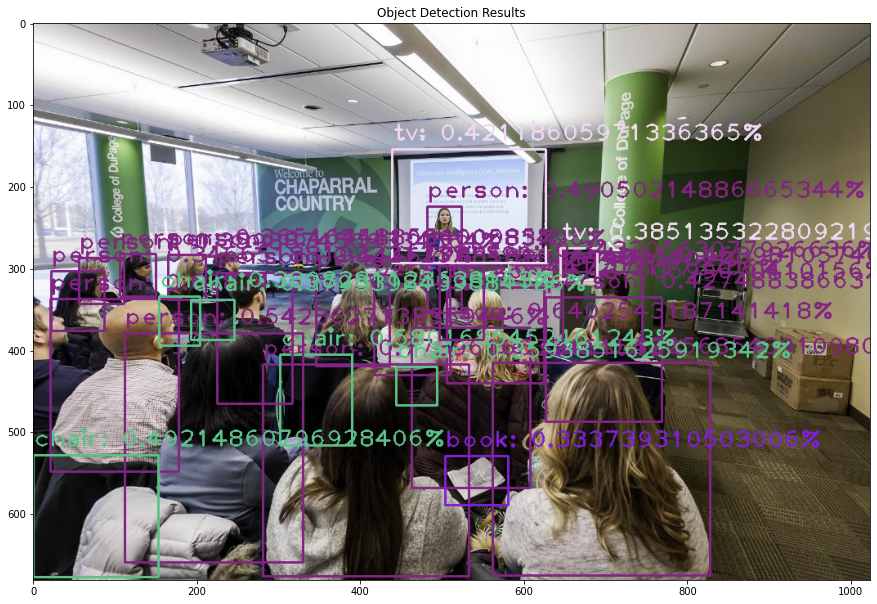

In [47]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/00001a21632de752.jpg'

object_detection(image_path, model, classes_name, max_output_size=50, iou_threshold=0.49, score_threshold=0.3, soft_nms_sigma=0.4)

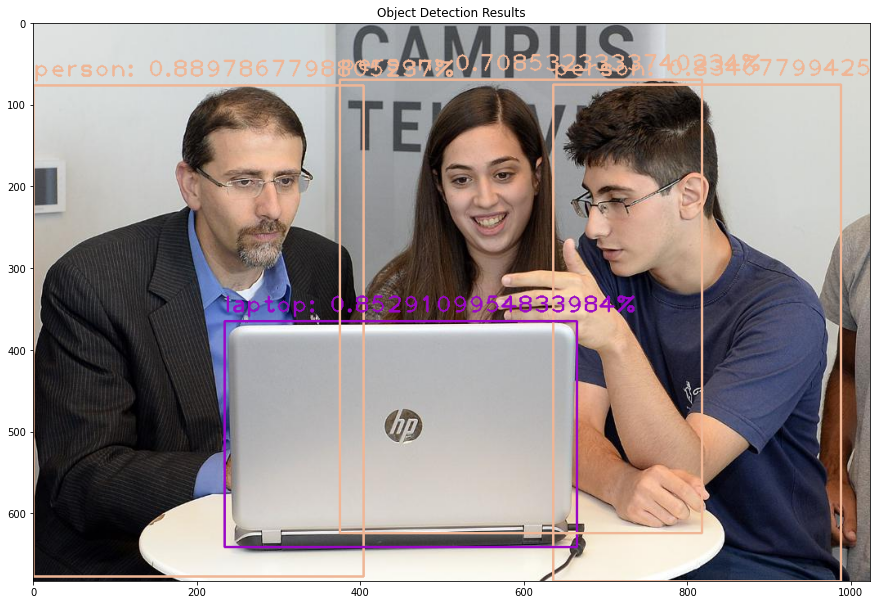

In [16]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/0003d1c3be9ed3d6.jpg'

object_detection(image_path, model, classes_name, max_output_size=50, iou_threshold=0.49, score_threshold=0.6, soft_nms_sigma=0.49)

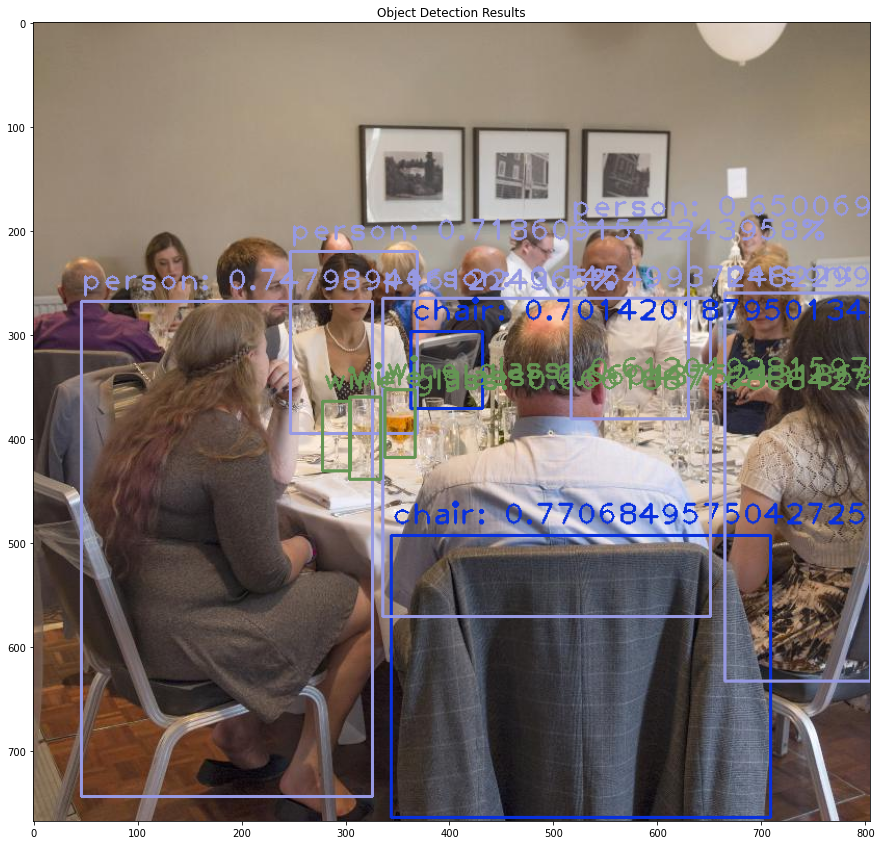

In [17]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/000f579533500448.jpg'

object_detection(image_path, model, classes_name, max_output_size=50, iou_threshold=0.49, score_threshold=0.6, soft_nms_sigma=0.49)

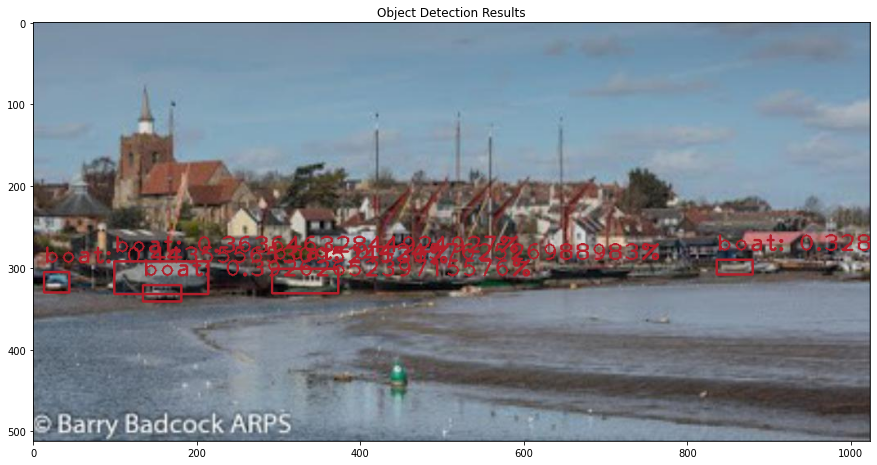

In [25]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/0026201b6d912efb.jpg'

object_detection(image_path, model, classes_name, max_output_size=50, iou_threshold=0.49, score_threshold=0.3, soft_nms_sigma=0.59)

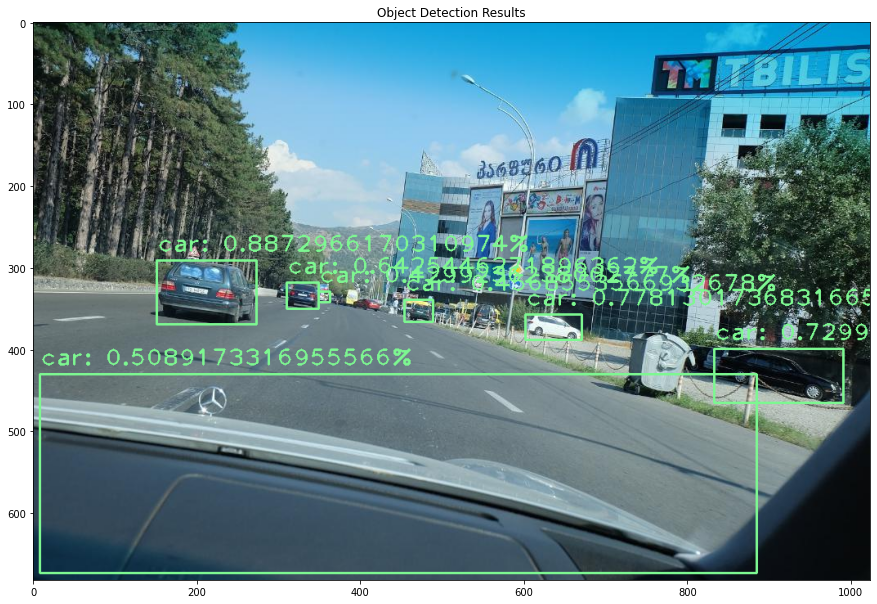

In [28]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/00246c2940caa984.jpg'

object_detection(image_path, model, classes_name, max_output_size=50, iou_threshold=0.49, score_threshold=0.4, soft_nms_sigma=0.49)

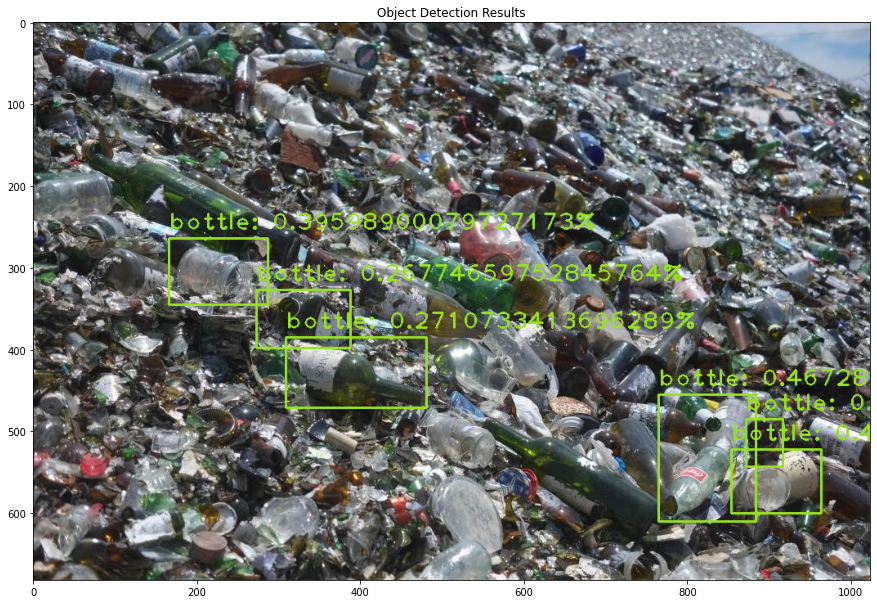

In [36]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/001b5a3eae515477.jpg'

object_detection(image_path, model, classes_name, max_output_size=100, iou_threshold=0.49, score_threshold=0.2, soft_nms_sigma=0.4)

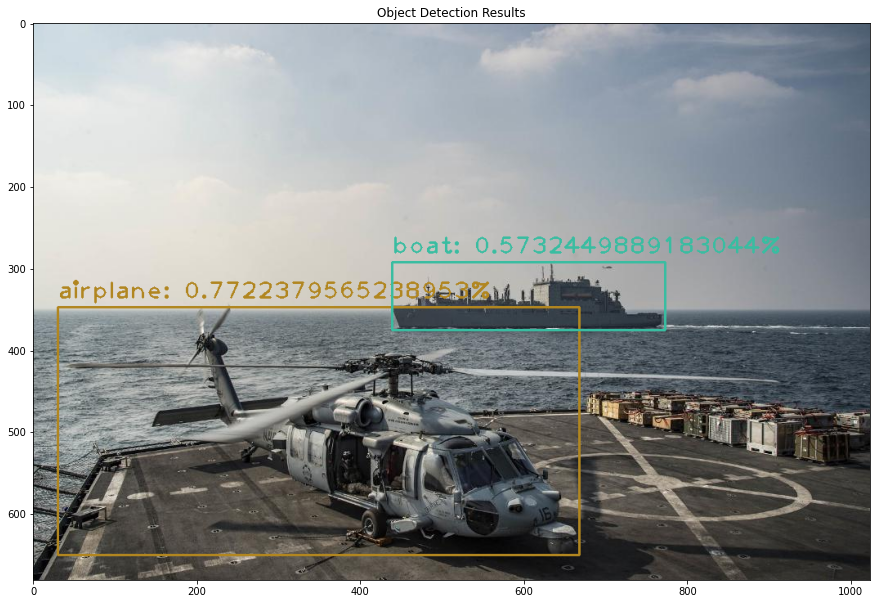

In [42]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/003177411d8813e7.jpg'

object_detection(image_path, model, classes_name, max_output_size=50, iou_threshold=0.49, score_threshold=0.3, soft_nms_sigma=0.4)

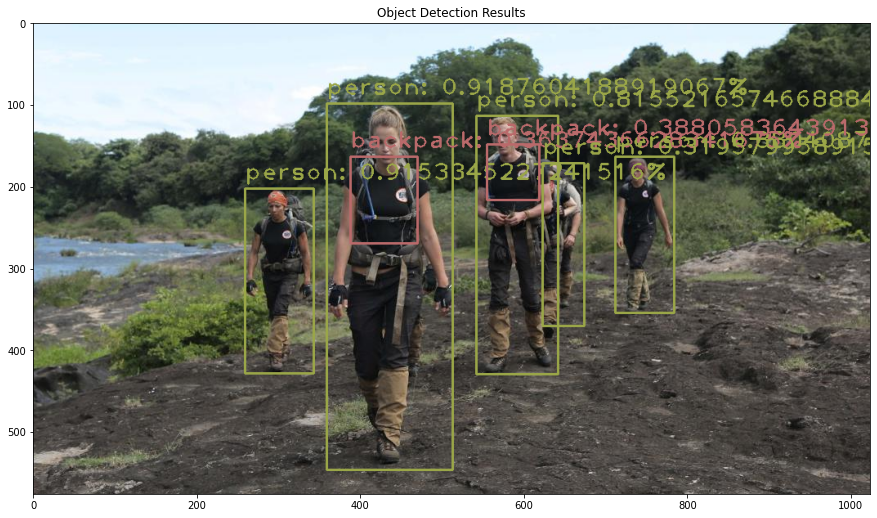

In [43]:
image_path = '/kaggle/input/open-images-2019-object-detection/test/00379950569d024c.jpg'

object_detection(image_path, model, classes_name, max_output_size=50, iou_threshold=0.49, score_threshold=0.3, soft_nms_sigma=0.4)